<a href="https://colab.research.google.com/github/srijan211/kaggle/blob/main/Capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import joblib

import plydata.cat_tools as cat
import plotnine as pn
from sklearn.model_selection import GridSearchCV


In [3]:
cdnow_raw_df = pd.read_csv('cdnow.csv')

# Display the first few rows of the dataset
print(cdnow_raw_df.head())

# Get a summary of the dataset
print(cdnow_raw_df.info())

   Unnamed: 0  customer_id        date  quantity  price
0           0            1  1997-01-01         1  11.77
1           1            2  1997-01-12         1  12.00
2           2            2  1997-01-12         5  77.00
3           3            3  1997-01-02         2  20.76
4           4            3  1997-03-30         2  20.76
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   69659 non-null  int64  
 1   customer_id  69659 non-null  int64  
 2   date         69659 non-null  object 
 3   quantity     69659 non-null  int64  
 4   price        69659 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.7+ MB
None


/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


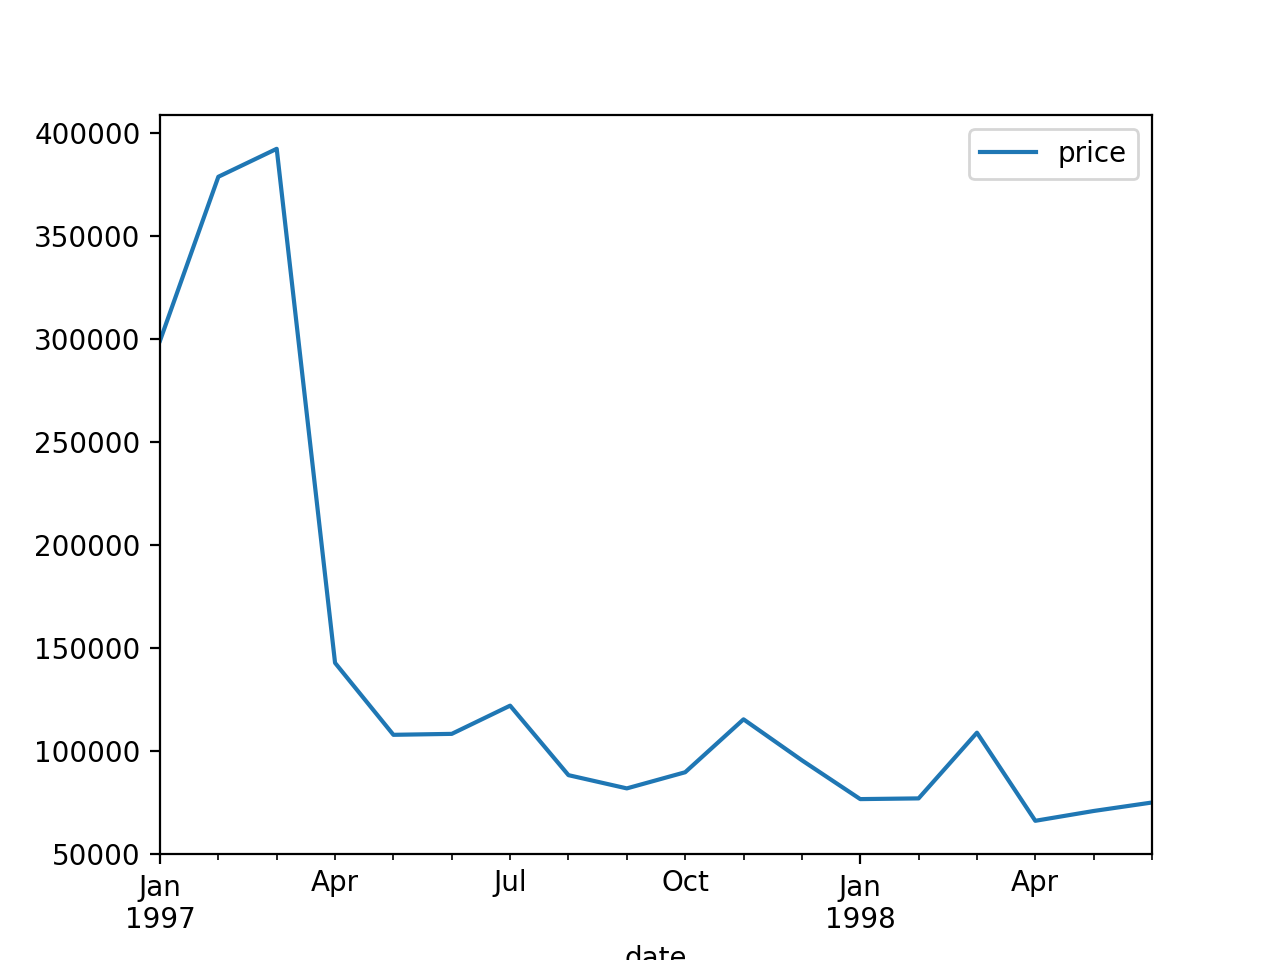

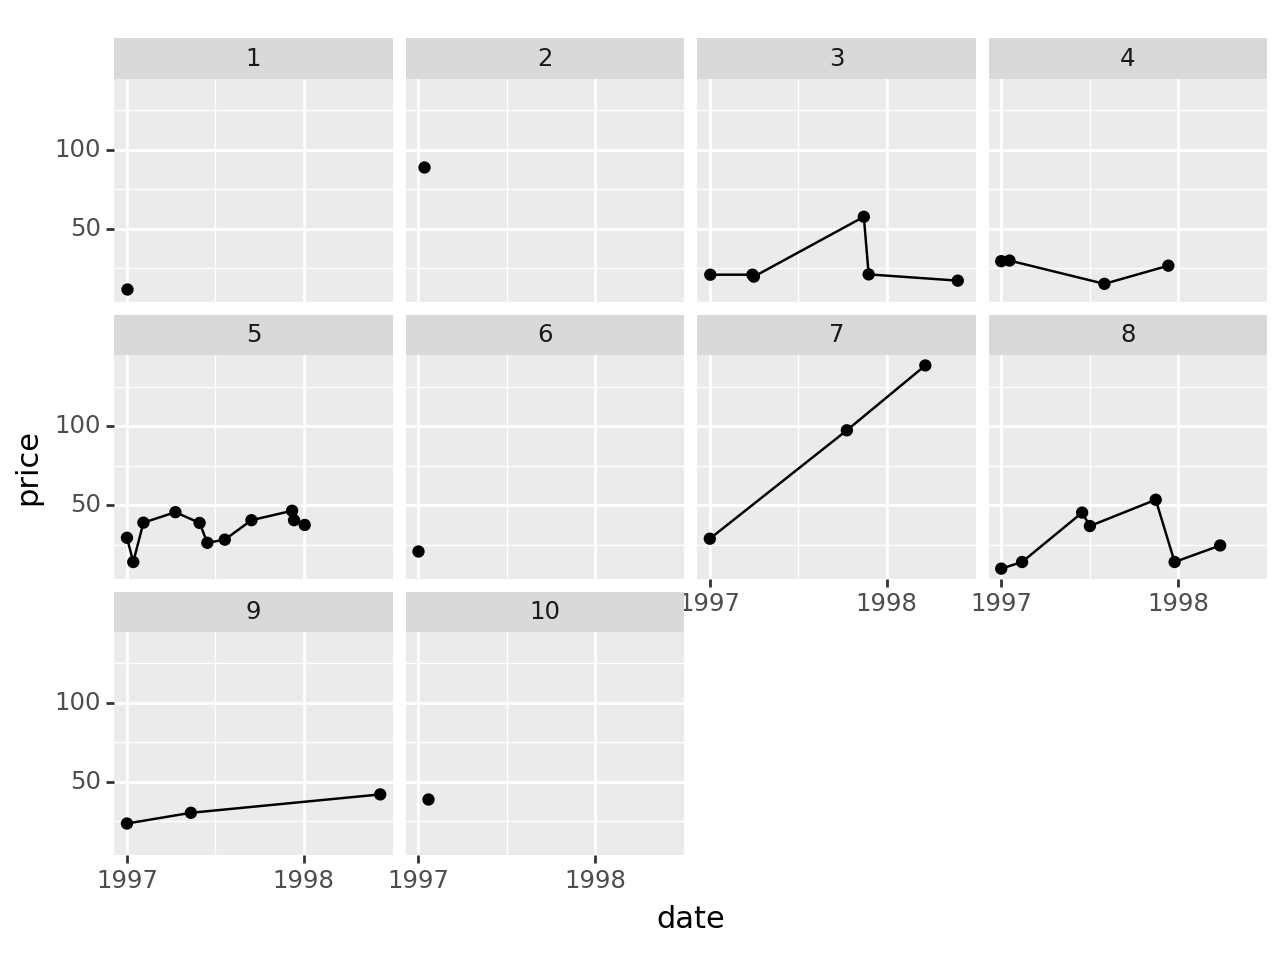

<Figure Size: (640 x 480)>

In [4]:
# Convert 'date' column to datetime and drop missing values
cdnow_df = cdnow_raw_df \
    .assign(date=lambda x: pd.to_datetime(x['date'].astype(str))) \
    .dropna()

# Get first purchase for each customer
cdnow_first_purchase_tbl = cdnow_df \
    .sort_values(['customer_id', 'date']) \
    .groupby('customer_id') \
    .first()

# Visualize: All purchases within cohort
cdnow_df \
    .reset_index() \
    .set_index('date')[['price']] \
    .resample(rule="MS").sum() \
    .plot()

# Visualize: Individual Customer Purchases
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[0:10]

cdnow_cust_id_subset_df = cdnow_df \
    [cdnow_df['customer_id'].isin(ids_selected)] \
    .groupby(['customer_id', 'date']) \
    .sum() \
    .reset_index()

# Corrected plot using plotnine
(
    pn.ggplot(cdnow_cust_id_subset_df, pn.aes('date', 'price', group='customer_id')) +
    pn.geom_line() +
    pn.geom_point() +
    pn.facet_wrap('customer_id') +
    pn.scale_x_date(date_breaks="1 year", date_labels="%Y")
)


In [5]:
n_days   = 90
max_date = cdnow_df['date'].max()
cutoff   = max_date - pd.to_timedelta(n_days, unit = "d")

temporal_in_df = cdnow_df \
    [cdnow_df['date'] <= cutoff]

temporal_out_df = cdnow_df \
    [cdnow_df['date'] > cutoff]


# 3.2 FEATURE ENGINEERING (RFM) ----
#   - Most challenging part
#   - 2-Stage Process
#   - Need to frame the problem
#   - Need to think about what features to include

# Make Targets from out data ----

# Make Targets from out data ----

# Exclude 'date' column before summing
targets_df = temporal_out_df \
    .drop(['quantity', 'date'], axis=1) \
    .groupby('customer_id') \
    .sum() \
    .rename({'price': 'spend_90_total'}, axis=1)

# Make Recency (Date) Features from in data ----
max_date = temporal_in_df['date'].max()

recency_features_df = temporal_in_df \
    [['customer_id', 'date']] \
    .groupby('customer_id') \
    .apply(
        lambda x: (max_date - x['date'].max()).days  # Calculate days since last purchase
    ) \
    .to_frame(name="recency")

# Make Frequency (Count) Features from in data ----
frequency_features_df = temporal_in_df \
    [['customer_id', 'date']] \
    .groupby('customer_id') \
    .count() \
    .rename(columns={'date': 'frequency'})  # Rename 'date' to 'frequency'

# Make Price (Monetary) Features from in data ----
price_features_df = temporal_in_df \
    .groupby('customer_id') \
    .aggregate(
        {
            'price': ["sum", "mean"]
        }
    ) \
    .set_axis(['price_sum', 'price_mean'], axis=1)

# 3.3 COMBINE FEATURES ----
features_df = pd.concat(
    [recency_features_df, frequency_features_df, price_features_df], axis=1
) \
    .merge(
        targets_df,
        left_index=True,
        right_index=True,
        how="left"
    ) \
    .fillna(0)

# Display the final features dataframe
features_df.head()


,recency,frequency,price_sum,price_mean,Unnamed: 0,spend_90_total
customer_id,,,,,,
1,455,1,11.77,11.770000,0.0,0.00
2,444,2,89.00,44.500000,0.0,0.00
3,127,5,139.47,27.894000,8.0,16.99
4,110,4,100.50,25.125000,0.0,0.00
5,88,11,385.61,35.055455,0.0,0.00


In [6]:
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

# 4.1 NEXT 90-DAY SPEND PREDICTION ----

y_spend = features_df['spend_90_total']

In [7]:
from sklearn.linear_model import LinearRegression

# Linear Regression Model
lr_reg_spec = LinearRegression()

# No hyperparameters to tune for Linear Regression, so just run GridSearchCV with default params
lr_reg_model = GridSearchCV(
    estimator=lr_reg_spec,
    param_grid={},  # Empty grid since no hyperparameters for linear regression
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

lr_reg_model.fit(X, y_spend)

# Results
lr_best_score = lr_reg_model.best_score_
lr_best_params = lr_reg_model.best_params_
lr_best_estimator = lr_reg_model.best_estimator_

predictions_lr = lr_reg_model.predict(X)
predictions_lr

array([ 0.87598375,  5.861861  , 16.55379679, ..., 11.33475184,
       -0.57603364,  5.52444874])

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Model
rf_reg_spec = RandomForestRegressor(random_state=123)

# Hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_reg_model = GridSearchCV(
    estimator=rf_reg_spec,
    param_grid=param_grid_rf,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

rf_reg_model.fit(X, y_spend)

# Results
rf_best_score = rf_reg_model.best_score_
rf_best_params = rf_reg_model.best_params_
rf_best_estimator = rf_reg_model.best_estimator_

predictions_rf = rf_reg_model.predict(X)
predictions_rf

array([ 0.60766049,  1.28036951, 12.47736098, ...,  4.06708769,
        1.81393586,  3.23629274])

In [10]:
from xgboost import XGBRegressor

# XGBoost Model
xgb_reg_spec = XGBRegressor(objective="reg:squarederror", random_state=123)

# Hyperparameter grid
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5]
}

xgb_reg_model = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

xgb_reg_model.fit(X, y_spend)

# Results
xgb_best_score = xgb_reg_model.best_score_
xgb_best_params = xgb_reg_model.best_params_
xgb_best_estimator = xgb_reg_model.best_estimator_

predictions_xgb = xgb_reg_model.predict(X)


In [11]:
from sklearn.neural_network import MLPRegressor

# Neural Network Model (MLPRegressor)
mlp_reg_spec = MLPRegressor(random_state=123, max_iter=1000)

# Hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

mlp_reg_model = GridSearchCV(
    estimator=mlp_reg_spec,
    param_grid=param_grid_mlp,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

mlp_reg_model.fit(X, y_spend)

# Results
mlp_best_score = mlp_reg_model.best_score_
mlp_best_params = mlp_reg_model.best_params_
mlp_best_estimator = mlp_reg_model.best_estimator_

predictions_mlp = mlp_reg_model.predict(X)


In [ ]:
from sklearn.svm import SVR

# Support Vector Regression Model
svr_reg_spec = SVR()

# Hyperparameter grid
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

svr_reg_model = GridSearchCV(
    estimator=svr_reg_spec,
    param_grid=param_grid_svr,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

svr_reg_model.fit(X, y_spend)

# Results
svr_best_score = svr_reg_model.best_score_
svr_best_params = svr_reg_model.best_params_
svr_best_estimator = svr_reg_model.best_estimator_

predictions_svr = svr_reg_model.predict(X)


In [ ]:
best_scores = {
    'Linear Regression': lr_best_score,
    'Random Forest': rf_best_score,
    'XGBoost': xgb_best_score,
    'Neural Network (MLP)': mlp_best_score,
    'Support Vector Regression': svr_best_score
}

best_params = {
    'Linear Regression': lr_best_params,
    'Random Forest': rf_best_params,
    'XGBoost': xgb_best_params,
    'Neural Network (MLP)': mlp_best_params,
    'Support Vector Regression': svr_best_params
}

best_estimators = {
    'Linear Regression': lr_best_estimator,
    'Random Forest': rf_best_estimator,
    'XGBoost': xgb_best_estimator,
    'Neural Network (MLP)': mlp_best_estimator,
    'Support Vector Regression': svr_best_estimator
}

print("Best Scores: ", best_scores)
print("Best Parameters: ", best_params)


In [ ]:
# Importance | Spend Amount Model
imp_spend_amount_dict = xgb_reg_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain')

imp_spend_amount_df = pd.DataFrame(
    data  = {
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
) \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'] , x['value'])
    )

pn.ggplot(
    pn.aes('feature', 'value'),
    data = imp_spend_amount_df
) \
    + pn.geom_col() \
    + pn.coord_flip()

# 5.0 SAVE WORK ----

# Save Predictions
predictions_df = pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
        features_df.reset_index()
    ],
    axis=1
)

predictions_df

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a function to evaluate the model using cross-validation
def evaluate_model(model, X, y):
    # Perform cross-validation for each metric
    cv_mae = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)
    cv_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_r2 = cross_val_score(model, X, y, scoring='r2', cv=5)

    # Calculate the mean and standard deviation for each metric
    mae_mean = -cv_mae.mean()
    mae_std = cv_mae.std()
    mse_mean = -cv_mse.mean()
    mse_std = cv_mse.std()
    r2_mean = cv_r2.mean()
    r2_std = cv_r2.std()

    return {
        'MAE': (mae_mean, mae_std),
        'MSE': (mse_mean, mse_std),
        'R-squared': (r2_mean, r2_std)
    }

# Example of using the function with XGBoost
xgb_results = evaluate_model(xgb_reg_model.best_estimator_, X, y_spend)

# Print results
print(f"XGBoost Results:")
print(f"MAE: {xgb_results['MAE'][0]:.4f} ± {xgb_results['MAE'][1]:.4f}")
print(f"MSE: {xgb_results['MSE'][0]:.4f} ± {xgb_results['MSE'][1]:.4f}")
print(f"R-squared: {xgb_results['R-squared'][0]:.4f} ± {xgb_results['R-squared'][1]:.4f}")

# Example of using the function with Linear Regression
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X, y_spend)
lr_results = evaluate_model(lr_model, X, y_spend)

print(f"\nLinear Regression Results:")
print(f"MAE: {lr_results['MAE'][0]:.4f} ± {lr_results['MAE'][1]:.4f}")
print(f"MSE: {lr_results['MSE'][0]:.4f} ± {lr_results['MSE'][1]:.4f}")
print(f"R-squared: {lr_results['R-squared'][0]:.4f} ± {lr_results['R-squared'][1]:.4f}")

# Example of using the function with Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(X, y_spend)
rf_results = evaluate_model(rf_model, X, y_spend)

print(f"\nRandom Forest Results:")
print(f"MAE: {rf_results['MAE'][0]:.4f} ± {rf_results['MAE'][1]:.4f}")
print(f"MSE: {rf_results['MSE'][0]:.4f} ± {rf_results['MSE'][1]:.4f}")
print(f"R-squared: {rf_results['R-squared'][0]:.4f} ± {rf_results['R-squared'][1]:.4f}")

# Example of using the function with SVR
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(X, y_spend)
svr_results = evaluate_model(svr_model, X, y_spend)

print(f"\nSupport Vector Regression (SVR) Results:")
print(f"MAE: {svr_results['MAE'][0]:.4f} ± {svr_results['MAE'][1]:.4f}")
print(f"MSE: {svr_results['MSE'][0]:.4f} ± {svr_results['MSE'][1]:.4f}")
print(f"R-squared: {svr_results['R-squared'][0]:.4f} ± {svr_results['R-squared'][1]:.4f}")

# Example of using the function with Neural Networks
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(random_state=123)
mlp_model.fit(X, y_spend)
mlp_results = evaluate_model(mlp_model, X, y_spend)

print(f"\nNeural Networks (MLP) Results:")
print(f"MAE: {mlp_results['MAE'][0]:.4f} ± {mlp_results['MAE'][1]:.4f}")
print(f"MSE: {mlp_results['MSE'][0]:.4f} ± {mlp_results['MSE'][1]:.4f}")
print(f"R-squared: {mlp_results['R-squared'][0]:.4f} ± {mlp_results['R-squared'][1]:.4f}")
